Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Maciej Wilhelmi"

---

In [2]:
import itertools
import pickle
from typing import List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# D-separacja

W trakcie ostatniej listy zadań wspomnieliśmy o tzw. **d-separowalności** zmiennych losowych (wierzchołków) w modelach graficznych. Dla zmiennych losowych $X, Y, Z$, jeśli $X$ oraz $Y$ są **d-separowalne** podczas obserwacji zmiennej $Z$, to $X$ i $Y$ są **niezależne warunkowo** pod warunkiem $Z$ - oznaczamy to jako $X \perp Y | Z$.

**Definicja d-separowalności**

Zmienne $X$ oraz $Y$ są d-separowalne podczas obserwacji $Z$, jeśli **wszystkie** ścieżki z wierzchołka $X$ do wierzchołka $Y$ są **zablokowane**.

**Definicja zablokowanej ścieżki**

Ścieżka między dwoma wierzchołkami jest **zablokowana względem $C$**, gdzie $C$ to zbiór zmiennych obserwowanych, jeśli ścieżka przechodzi przez wierzchołek $v$, w taki sposób że (jedna z opcji):

- połączenie jest typu **head-tail** lub **tail-tail** oraz $v \in C$,
- połączenie jest typu **head-head** oraz $v \notin C$ oraz żaden z **potomków $v$ nie należy do $C$**

![](assets/d_sep.png)

# Przykład

In [3]:
def get_graph():
    G = nx.DiGraph()
    G.add_edges_from([
        (1, 3), (2, 3),
        (3, 4), (3, 8),
        (4, 6), (5, 6),
        (6, 7)
    ])
    
    G.node_pos = {
        1: (0, 0), 2: (2, 0), 
        3: (1, -1), 
        5: (-2, -2), 4: (0, -2), 8: (2, -2),
        6: (-1, -3), 7: (-1, -5)
    }

    return G


def visualize(G, C):
    colors = ['gray' if v in C else 'red' for v in G.nodes()]
    nx.draw(G, with_labels=True, node_color=colors, pos=G.node_pos, node_size=2000)

Zbiór $C$ jest również zwany **zbiorem warunkującym** (ang. *conditioning_set*). Tutaj $C = \{3\}$.

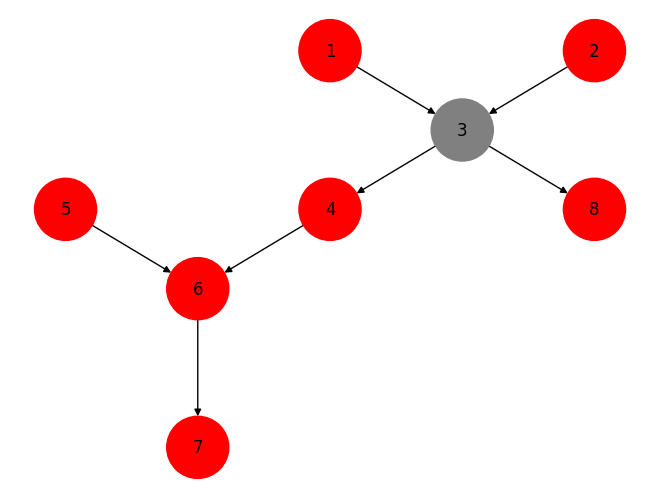

In [4]:
graph = get_graph()
conditioning_set = {3}

visualize(G=graph, C=conditioning_set)

Poszukajmy zależności **head-tail** - przykłady:
- **"1 -> 3 -> 4"**, widzimy, że $3 \in C$, zatem "1" oraz "4" są d-separowalne
- taka sama sytuacja jest w przypadku **"2 -> 3 -> 8"**, **"1 -> 3 -> 8"** oraz **"2 -> 3 -> 4"**
- dla ścieżki **"4 -> 6 -> 7"** widzimy, że $6 \notin C$ zatem "4" i "7" nie są d-separowalne
- analogiczny brak d-separowalności widzimy dla ścieżki: **"5 -> 6 -> 7"**

Dla relacji **tail-tail** w tym modelu (grafie) mamy tylko jeden przykład: **"4 <- 3 -> 8"**. Skoro $3 \in C$ to zmienne "4" oraz "8" są d-separowalne.

W przypadku relacji **head-head** mamy tylko dwie takie trójki:
- **"1 -> 3 <- 2"** - brak d-separowalności
- **"5 -> 6 <- 4"** - "5" oraz "4" są d-separowalne, ponieważ $6 \notin C$ oraz żaden potomek (tutaj: "7") również nie należy do $C$

# Uwaga
Dotychczas rozważaliśmy tylko trójki zmiennych/wierzchołków (tzn. ścieżki o długości 3), jednak możemy sprawdzać d-separowalność między bardziej oddalonymi wierzchołkami. Musimy wtedy sprawdzić, czy **każda ścieżka** między nimi zawiera **zablokowaną trójkę** (korzystając z reguł head-head, head-tail lub tail-tail).

# Zadania

## Zadanie 1 (0.75 + 0.25 pkt)

Zaimplementuj funkcję **is_blocking_triple**, która dla dowolnych 3 wierzchołków (zmiennych losowych) sprawdzi czy tworzą ścieżkę blokującą.

Podpowiedzi: 
- użyj metody `has_edge()` klasy `nx.Graph`, aby sprawdzić czy graf posiada połączenie (krawędź) między węzłami
- użyj funkcji `nx.descendants()`, aby wyznaczyć potomków dane wierzchołka

In [5]:
Node = int


def is_blocking_triple(
    x: Node, v: Node, y: Node, 
    G: nx.Graph, C: set,
) -> bool:
    # 1. head-tail oraz 𝑣∈𝐶
    if G.has_edge(x,v) and G.has_edge(v,y) and v in C:
        return True
    if G.has_edge(y,v) and G.has_edge(v,x) and v in C:
        return True
    
    # 2. tail-tail oraz 𝑣∈𝐶
    if G.has_edge(v,x) and G.has_edge(v,y) and v in C:
        return True
    
    # 3. połączenie jest typu head-head oraz 𝑣∉𝐶 oraz żaden z potomków 𝑣 nie należy do  𝐶v
    # head-head
    if G.has_edge(x, v) and G.has_edge(y, v) and not(v in C):
        for w in nx.descendants(G, v):
            if w in C:
                return False
        return True
#     if G.has_edge(x,v) and G.has_edge(y,v) and not(v in C) and not(nx.descendants(G, v) in C):
#         print('fff')
#         return True
    return False

Sprawdźmy czy funkcja działa dla powyższego przykładu:

In [6]:
assert is_blocking_triple(x=1, v=3, y=4, G=graph, C=conditioning_set)

expected_blocked_triples = [
    # Head-tail
    (1, 3, 4),
    (1, 3, 8),
    (2, 3, 4),
    (2, 3, 8),
    
    # Tail-tail
    (4, 3, 8),
    
    # Head-head
    (5, 6, 4),
]

assert all(
    is_blocking_triple(
        x=t[0], v=t[1], y=t[2], 
        G=graph, C=conditioning_set,
    ) 
    for x, v, y in expected_blocked_triples
    for t in ((x, v, y), (y, v, x))
)

expected_non_blocked_triples = [
    # Head-tail
    (4, 6, 7),
    (5, 6, 7),
    
    # Head-head
    (1, 3, 2),
]

assert all(
    not is_blocking_triple(
        x=t[0], v=t[1], y=t[2], 
        G=graph, C=conditioning_set,
    ) 
    for x, v, y in expected_non_blocked_triples
    for t in ((x, v, y), (y, v, x))
)

Zaimplementujmy funkcję, która dla podanego grafu $G$ oraz zbioru warunkującego $C$ wyznaczy wszystkie zablokowane trójki:

In [7]:
def get_all_blocking_triples(
    G: nx.Graph, 
    C: set,
) -> List[Tuple[Node, Node, Node]]:
    blocking_triples = []
    
    for x, v, y in sorted(itertools.permutations(G.nodes(), r=3)):
        if is_blocking_triple(x=x, v=v, y=y, G=G, C=C):
            blocking_triples.append((x, v, y))
            
    return blocking_triples

In [8]:
blocking_triples = get_all_blocking_triples(G=graph, C=conditioning_set)

print("Number of blocking triples:", len(blocking_triples))

blocking_triples

Number of blocking triples: 12


[(1, 3, 4),
 (1, 3, 8),
 (2, 3, 4),
 (2, 3, 8),
 (4, 3, 1),
 (4, 3, 2),
 (4, 3, 8),
 (4, 6, 5),
 (5, 6, 4),
 (8, 3, 1),
 (8, 3, 2),
 (8, 3, 4)]

## Zadanie 2 (0.75 + 0.25 pkt)

Zaimplementuj funkcję **is_d_separable**, która dla dowolnych dwóch wierzchołków $x$ oraz $y$ sprawdzi czy są one d-separowalne. Odległość między tymi wierzchołkami w grafie może być większa niż 3, musimy sprawdzić czy wszystkie ścieżki między tymi wierzchołkami są zablokowane.

**Uwaga** Nie rozważamy d-separowalności w przypadku kiedy (zwróć wtedy `"N/A"`):
- wierzchołki są bezpośrednio połączone
- jeden z wierzchołków jest obserwowany

Wykorzystaj podaną funkcję `get_all_paths()` do wyznaczenia wszystkich ścieżek między wierzchołkami.

In [9]:
def get_all_paths(G: nx.Graph, x: Node, y: Node) -> List[List[Node]]:
    return list(nx.all_simple_paths(G=nx.Graph(G), source=x, target=y))

In [10]:
def is_d_separable(
    x: Node, y: Node, 
    G: nx.Graph, C: set, 
    blocking_triples: Optional[List[List[Node]]] = None,
) -> Union[str, bool]:
    """Checks if `x` and `y` are d-separable given C.
    
    If d-separation is not applicable return 'N/A',
    otherwise return True/False, denoting whether 
    variables are d-separable or not.
    """
    # Sprawdzenie warunków dla "N/A"
    if G.has_edge(x, y) or G.has_edge(y, x) or x in C or y in C:
        return "N/A"
    
    # Wszystkie ścieżki
    paths = get_all_paths(G, x, y)
    
    # Wszystkie blokujące trójki
    if blocking_triples is None:
        blocking_triples = get_all_blocking_triples(G, C)
        
    blocking_triples = [set(triple) for triple in blocking_triples]
    
    # Sprawdzenie czy wszystkie ścieżki są zablokowane
    for path in paths:
#         print(path)
        is_blocked = False
        for i in range(len(path)-2):
            triple = {path[i], path[i+1], path[i+2]}
#             print(triple, blocking_triples)
            if triple in blocking_triples:
#                 print('cswvweabvewea')
                is_blocked = True
#                 break
        if not is_blocked:
            return False   
    # Kiedys wszystkie są zablokowane:
    return True
    

is_d_separable(1,4,graph,conditioning_set)

True

Wyznaczmy d-separowalność dla wszystkich par wierzchołków:

In [11]:
def check_d_separability_for_all_node_pairs(G, C, d_sep_fn):
    records = []

    for x, y in sorted(itertools.permutations(G.nodes(), r=2)):
        records.append({
            'x': x, 
            'y': y, 
            'd_sep': d_sep_fn(x=x, y=y, G=G, C=C),
        })
        
    return pd.DataFrame.from_records(records)


df = check_d_separability_for_all_node_pairs(
    G=graph,
    C=conditioning_set,
    d_sep_fn=is_d_separable,
)

Pary d-separowalne:

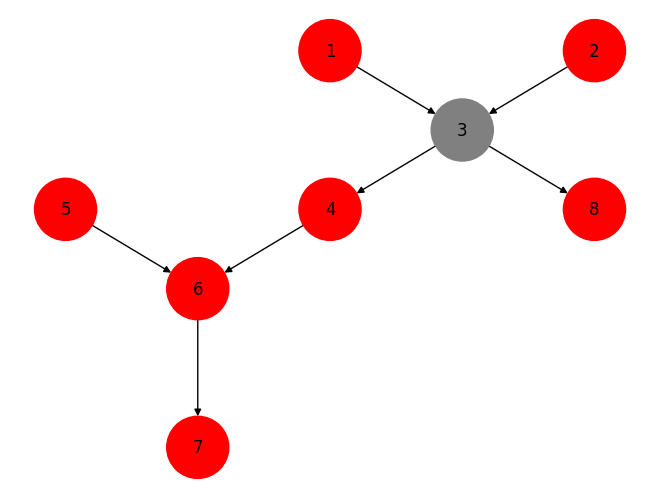

In [12]:
visualize(G=graph, C=conditioning_set)

In [13]:
df[df.d_sep == True]

,x,y,d_sep
2,1,4,True
3,1,5,True
4,1,6,True
5,1,7,True
6,1,8,True
9,2,4,True
10,2,5,True
11,2,6,True
12,2,7,True
13,2,8,True


Pary nie d-separowalne:

In [14]:
df[df.d_sep == False]

,x,y,d_sep
0,1,2,False
7,2,1,False
26,4,7,False
33,5,7,False
45,7,4,False
46,7,5,False


Sytuacje nieokreślone:

In [15]:
df[df.d_sep == 'N/A']

,x,y,d_sep
1,1,3,N/A
8,2,3,N/A
14,3,1,N/A
15,3,2,N/A
16,3,4,N/A
17,3,5,N/A
18,3,6,N/A
19,3,7,N/A
20,3,8,N/A
23,4,3,N/A


## Testy automatyczne

In [16]:
def check(graph, conditioning_set, d_sep_fn, expected_df_path):
    actual_df = check_d_separability_for_all_node_pairs(
        G=graph,
        C=conditioning_set,
        d_sep_fn=d_sep_fn,
    )
    
#     visualize(G=graph, C=conditioning_set)
    
    with open(expected_df_path, 'rb') as fin:
        expected_df = pickle.load(fin)
    
    num_errors = 0
    
#     print(expected_df)
    for (_, exp_row), act_d_sep in zip(expected_df.iterrows(), actual_df.d_sep):
        if exp_row.d_sep != act_d_sep:
            print(
#                 f'* Error for ({exp_row}, {exp_row})\n'
                f'\tExpected: {exp_row.d_sep}\n'
                f'\tGot: {act_d_sep}'
            )
            num_errors += 1
            
    if num_errors > 0:
        total_rows = expected_df.shape[0]
        error_rate = np.round(num_errors / total_rows * 100, 2)
        print(f'Error rate: {num_errors}/{total_rows} -> {error_rate}%')
    else:
        print('No errors found! Passed')


check(
    graph=get_graph(),
    conditioning_set={7},
    d_sep_fn=is_d_separable,
    expected_df_path='data/dsep/first-c7.pkl',
)

check(
    graph=get_graph(),
    conditioning_set={3, 7},
    d_sep_fn=is_d_separable,
    expected_df_path='data/dsep/first-c37.pkl',
)

second_graph = graph.copy()
second_graph.add_edge(1, 5)

check(
    graph=second_graph,
    conditioning_set={6},
    d_sep_fn=is_d_separable,
    expected_df_path='data/dsep/second-c6.pkl',
)

second_graph = graph.copy()
second_graph.add_edge(1, 5)

check(
    graph=second_graph,
    conditioning_set={3, 6},
    d_sep_fn=is_d_separable,
    expected_df_path='data/dsep/second-c36.pkl',
)

No errors found! Passed
No errors found! Passed
No errors found! Passed
No errors found! Passed


In [17]:
def check(graph, conditioning_set, d_sep_fn, expected_df_path):
    actual_df = check_d_separability_for_all_node_pairs(
        G=graph,
        C=conditioning_set,
        d_sep_fn=d_sep_fn,
    )
    
    with open(expected_df_path, 'rb') as fin:
        expected_df = pickle.load(fin)
    
    num_errors = 0
        
    for (_, exp_row), act_d_sep in zip(expected_df.iterrows(), actual_df.d_sep):
        if exp_row.d_sep != act_d_sep:
            print(
                f'* Error for ({exp_row.v1}, {exp_row.v2})\n'
                f'\tExpected: {exp_row.d_sep}\n'
                f'\tGot: {act_d_sep}'
            )
            num_errors += 1
            
    if num_errors > 0:
        total_rows = expected_df.shape[0]
        error_rate = np.round(num_errors / total_rows * 100, 2)
        print(f'Error rate: {num_errors}/{total_rows} -> {error_rate}%')
    else:
        print('No errors found! Passed')


check(
    graph=get_graph(),
    conditioning_set={7},
    d_sep_fn=is_d_separable,
    expected_df_path='data/dsep/first-c7.pkl',
)

check(
    graph=get_graph(),
    conditioning_set={3, 7},
    d_sep_fn=is_d_separable,
    expected_df_path='data/dsep/first-c37.pkl',
)

second_graph = graph.copy()
second_graph.add_edge(1, 5)

check(
    graph=second_graph,
    conditioning_set={6},
    d_sep_fn=is_d_separable,
    expected_df_path='data/dsep/second-c6.pkl',
)

second_graph = graph.copy()
second_graph.add_edge(1, 5)

check(
    graph=second_graph,
    conditioning_set={3, 6},
    d_sep_fn=is_d_separable,
    expected_df_path='data/dsep/second-c36.pkl',
)

No errors found! Passed
No errors found! Passed
No errors found! Passed
No errors found! Passed


In [18]:
# TU WPISZ KOD
# raise NotImplementedError()